# Capstone Project - The Battle of the Neighborhoods
---

## Introduction: Business Problem

In this project I will try to find an optimal location for opening a restaurant in New Delhi.

In here I will try to detect **locations that are not already crowded with restaurants**. In order to give maximum benefit to the stakeholder opening a restaurant It would be preferable to have locations **as close to city center as possible**.

Data science will be used to find a few most promising neighborhoods in the New Delhi area.

## Data

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)

Following data sources will be needed to extract/generate the required information:
* Centers of candidate areas will be generated using web scraping this website -**https://www.latlong.net/category/districts-102-16.html**. After Web surfing I was able to land on this website where the Data for districts of New Delhi is available but unfortunately it has to be scraped and converted into ready to use dataframe
* Number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

In [207]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np

In [208]:
source=requests.get('https://www.latlong.net/category/districts-102-16.html').text
soup=BeautifulSoup(source,'lxml')
table = soup.find('table')

# rows=table.find_all('tr')

In [209]:
td=table.find_all('td')
district =[]
latitude =[]
longitude =[]
count=0
for t in td:
    try:
        district.append(t.a.text)
        count=0
#         print(t.a.text)
        
    except:
        if(count==0):
            latitude.append(t.text)
            count=1
        elif(count==1):
            longitude.append(t.text)

In [210]:
df = pd.DataFrame(list(zip(district, latitude, longitude)),columns =['District', 'Latitude', 'Longitude'])

### DATA Cleaning
* Data frame has been created but the data consists of many non required districts of India which are not in the current focus of this project
* Hence on dropping the non essential district we get ready to use data

In [211]:
for dist in range(len(df['District'])):
#     dist=dist-1
#     print("District Index is :",dist)
    if(df['District'][dist].find('Delhi')==-1):
        df.drop(index=dist, inplace=True)
#         print('Delhi not found:',df['District'][dist].find('Delhi'))
#         print()
#         df.drop(df.index[dist])
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)
df.head(20)

,District,Latitude,Longitude
0,"Green Park, Delhi, New Delhi, India",28.549999,77.199997
1,"Rajouri Garden, New Delhi, Delhi, India",28.641529,77.120918
2,"Bindapur, New Delhi, Delhi, India",28.610722,77.065971
3,"Karkardooma, Anand Vihar, Delhi, India",28.652946,77.302284
4,"Dilshad Garden, New Delhi, Delhi, India",28.683903,77.315094
5,"Karol Bagh, New Delhi, Delhi, India",28.661369,77.194405
6,"Okhla I, Okhla Industrial Area, New Delhi, Del...",28.525377,77.280106
7,"Lajpat Nagar, New Delhi, Delhi, India",28.569271,77.244110
8,"Aerocity, Indira Gandhi International Airport,...",28.550421,77.121765
9,"Dayalpur, Tukhmirpur, Delhi, New Delhi, India",28.718573,77.261353


## METHODOLOGY
---

* Data for the districts is set and now is the time getting the information for restaurants in the vicinity of this districts
* For getting this information we will use the Foursquare API
* We will get the numbers of the restaurant in an area and limit the radius for each area so as to get a figure to work on for each area

##### EXTRACTION OF THE DATA USING FOUR SQUARE API

In [212]:
CLIENT_ID=''
CLIENT_SECRET=''
VERSION=''
LIMIT=100
radius=700

* Now lets define a function to extract the data using Foursquare API
* This function will get the details for the venues which can be closely classified as an eating joint in a dsitrict in New Delhi

In [213]:
def get_Venues(lat,lng):
    
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df_v = pd.DataFrame(venue_details,columns=column_names)
    return df_v

#### Gliding forward
* Lets extract the data for each district and sum it up as a number
* Numbers for each district will be added into a new column in the existing dataframe
* The lowest number of restaurant in a district will suggest it as a most suitable location for opening the restaurant

In [214]:
df['Total']=""
c=0
for dist in df.values.tolist():
    district,lat,long,Tot=dist
    df['Total'][c]=len(get_Venues(df['Latitude'][c],df['Longitude'][c])['Name'])
    c=c+1
df.head()

,District,Latitude,Longitude,Total
0,"Green Park, Delhi, New Delhi, India",28.549999,77.199997,35
1,"Rajouri Garden, New Delhi, Delhi, India",28.641529,77.120918,8
2,"Bindapur, New Delhi, Delhi, India",28.610722,77.065971,2
3,"Karkardooma, Anand Vihar, Delhi, India",28.652946,77.302284,11
4,"Dilshad Garden, New Delhi, Delhi, India",28.683903,77.315094,3


#### Plot a Bar Chart to get and idea of no of Restaurant in a District
* It is quite evident from the Bar Chart below that the most numbers of the restaurant are available in the Green Park, Delhi Area, Aerocity and in Lajpat Nagar Area


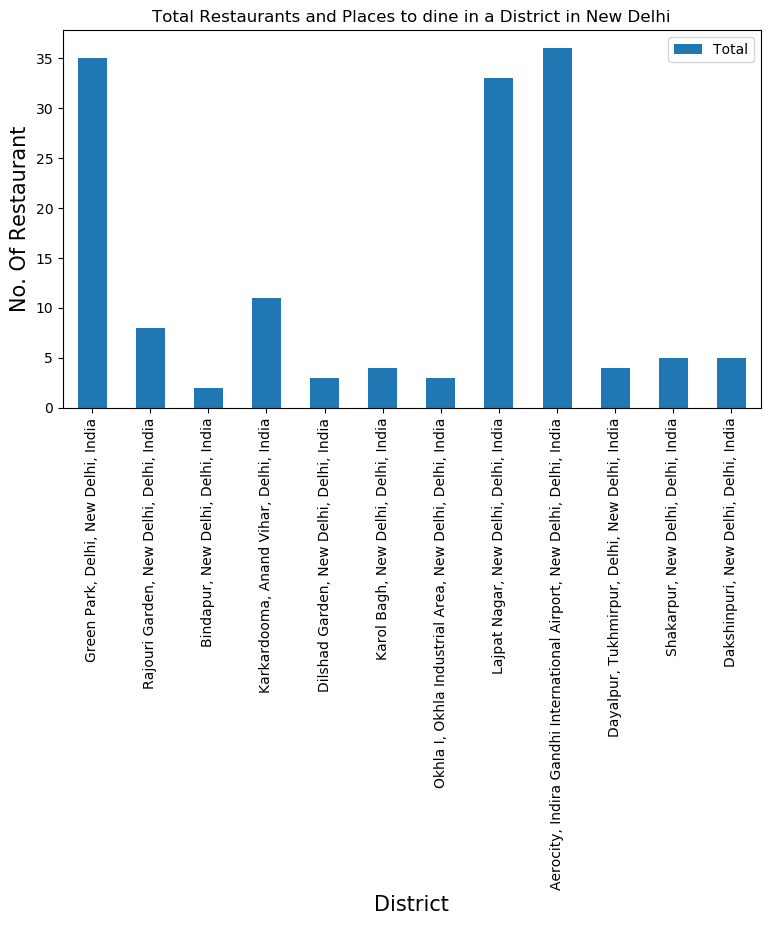

In [223]:

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt



plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Total Restaurants and Places to dine in a District in New Delhi')
#On x-axis
plt.xlabel('District', fontsize = 15)
#On y-axis
plt.ylabel('No. Of Restaurant', fontsize=15)
#giving a bar plot
df['Total'].plot(kind='bar')
plt.xticks(np.arange(12),df['District'])
#legend
plt.legend()
#displays the plot
plt.show()

## RESULT
---

From the above analysis it is evident that the best location to open the restaurant in Delhi is Bindapur New Delhi Area followed by Dilshad Garden. 

## CONCLUSION
---
The above analysis can be vastly improved with an addition of -
 * population data of the districts
 * Crime Rate data of a district
 * Real Estate cost of an area
 * Per Capita Income of people living in an area etc.
 
The type of restaurants can also be decided as per the ratings of the already existing restaurants in an area.